In [2]:
%load_ext autoreload
%autoreload 2


import sys
import os

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier
from rlace import solve_adv_game

from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import warnings
import argparse
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import scipy
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
from rlace import init_classifier
from collections import Counter

unable to import 'smart_open.gcs', disabling that module


In [2]:
os.mkdir("projs-2d")

FileExistsError: [Errno 17] File exists: 'projs-2d'

In [3]:
bios_data_path = "../WWW/rlace/bios/data/bios_data"
bios_encodings_path = "../WWW/rlace/bios/data/encodings/freezed"

data = []
for mode in ["train", "dev", "test"]:
    with open(bios_data_path + "/" + "{}.pickle".format(mode), "rb") as f:
        data.append(pickle.load(f))
        
train,dev,test = data
gender2ind = {"m": 0, "f": 1}
train_profs, dev_profs = np.array([d["p"] for d in train]), np.array([d["p"] for d in dev])
train_gender, dev_gender = np.array([gender2ind[d["g"]] for d in train]), np.array([gender2ind[d["g"]] for d in dev])


data = []
for mode in ["train", "dev", "test"]:
    with open(bios_encodings_path + "/" + "{}_cls.npy".format(mode), "rb") as f:
        data.append(np.load(f))
        
train_x, dev_x, test_x = data
pca = PCA(n_components=128, random_state=0)
pca.fit(train_x)
train_x = pca.transform(train_x)
dev_x = pca.transform(dev_x)
test_x = pca.transform(test_x)

print(np.sum(pca.explained_variance_ratio_))

0.850898423710952


In [5]:
clf = init_classifier()
clf.fit(train_x, train_profs)
clf.score(train_x, train_profs)

0.777251574048727

In [6]:
clf = init_classifier()
clf.fit(train_x, train_gender)
clf.score(train_x, train_gender)

0.9961166946932072

## binary Y,Z, strongly balanced setting.

In [7]:
def generate_balanced_binary_dataset(data, x, profs, gender, two_profs,max_number_examples=1e6):
    
    prof1,prof2 = two_profs
    is_prof_1 = x[profs==prof1]
    is_prof_2 = x[profs==prof2]
    
    is_prof1_male = x[(profs==prof1) & (gender==0)]
    is_prof1_female = x[(profs==prof1) & (gender==1)]
    is_prof2_male = x[(profs==prof2) & (gender==0)]
    is_prof2_female = x[(profs==prof2) & (gender==1)]
    n = min(max_number_examples, min(len(is_prof1_male), len(is_prof1_female), len(is_prof2_male), len(is_prof2_female)))
    
    prof1_x = np.concatenate([is_prof1_male[:n], is_prof1_female[:n]], axis=0)
    prof1_gender = np.array([0] * n + [1] * n)
    prof1_prof = np.array([prof1] * 2*n)
    
    prof2_x = np.concatenate([is_prof2_male[:n], is_prof2_female[:n]], axis=0)
    prof2_gender = np.array([0] * n + [1] * n)
    prof2_prof = np.array([prof2] * 2*n)
        
    x = np.concatenate([prof1_x, prof2_x], axis=0)
    profs = np.concatenate([prof1_prof, prof2_prof])
    gender = np.concatenate([prof1_gender, prof2_gender])
    
    #random.seed(0)
    #np.random.seed(0)
    
    x,profs,gender = shuffle(x,profs,gender)
    
    return x,profs,gender

def generate_globally_balanced_locally_imbalanced_binary_dataset(data, x, profs, gender, two_profs ,
                                                                 max_number_examples=1e6
                                                                ,prop_female=0.5):
    """
    Generate globally balanced data w.r.t Y and Z, but imbalanced wrt Z within each professsion y.
    x: the vectors
    profs: a numpy array containing the profession corresponding to each vector in x
    gender: a binary numpy array with the gender corresponding to each vector in x
    two_profs: two professions to use (a tuple of strings)
    max_number_examples: unused, ignore
    prop_female: the proportion of females in the first profession
    """
    prof1,prof2 = two_profs
    
    # partition vectors by professor & gender
    
    is_prof_1 = x[profs==prof1]
    is_prof_2 = x[profs==prof2]
    is_prof1_male = x[(profs==prof1) & (gender==0)]
    is_prof1_female = x[(profs==prof1) & (gender==1)]
    is_prof2_male = x[(profs==prof2) & (gender==0)]
    is_prof2_female = x[(profs==prof2) & (gender==1)]
    
    prop_female_prof1 = gender[profs==prof1].mean()
    prop_female_prof2 = gender[profs==prof2].mean()
    
    # choose the number n of vectors from each of the two professors, and the number m of females 
    #in the first profession
    n = min(len(is_prof1_male), len(is_prof1_female), len(is_prof2_male),len(is_prof2_female))
    m = int(n * prop_female)
    
    # create final vectors and labels
    prof1_x = np.concatenate([is_prof1_female[:m], is_prof1_male[:n-m]])
    prof2_x = np.concatenate([is_prof2_male[:m], is_prof2_female[:n-m]])
    prof1_prof = np.array([prof1] *n)
    prof2_prof = np.array([prof2] *n)
    prof1_gender = np.array([1] * m + [0] * (n-m))
    prof2_gender = np.array([0] * m + [1] * (n-m))
    
    x = np.concatenate([prof1_x, prof2_x], axis=0) # vectors
    profs = np.concatenate([prof1_prof, prof2_prof]) # profession labels
    gender = np.concatenate([prof1_gender, prof2_gender]) # gender labels
    
    x,profs,gender = shuffle(x,profs,gender)
    
    return x,profs,gender


def generate_globally_imbalanced_binary_dataset(data, x, profs, gender, two_profs,max_number_examples=1e6
                                                                ,prop_female=0.5):
    
    """
    Generate globally balanced data w.r.t Y and imbalanced wrt Z (where prop_female of BOTH professions are
    female)
    x: the input vectors
    profs: a numpy array containing the profession corresponding to each vector in x
    gender: a binary numpy array with the gender corresponding to each vector in x
    two_profs: two professions to use (a tuple of strings)
    max_number_examples: unused, ignore
    prop_female: the proportion of females in the first profession
    """
    prof1,prof2 = two_profs
    
    # partition vectors by professor & gender
    
    is_prof_1 = x[profs==prof1]
    is_prof_2 = x[profs==prof2]
    is_prof1_male = x[(profs==prof1) & (gender==0)]
    is_prof1_female = x[(profs==prof1) & (gender==1)]
    is_prof2_male = x[(profs==prof2) & (gender==0)]
    is_prof2_female = x[(profs==prof2) & (gender==1)]
    
    prop_female_prof1 = gender[profs==prof1].mean()
    prop_female_prof2 = gender[profs==prof2].mean()
    
    # choose the number n of vectors from each of the two professors, and the number m of females 
    #in the first profession
    n = min(len(is_prof1_male), len(is_prof1_female), len(is_prof2_male),len(is_prof2_female))
    
    m = int(n * prop_female)    
    # create final vectors and labels
    prof1_x = np.concatenate([is_prof1_female[:m], is_prof1_male[:n-m]])
    prof2_x = np.concatenate([is_prof2_female[:m], is_prof2_male[:n-m]])
    prof1_prof = np.array([prof1] *n)
    prof2_prof = np.array([prof2] *n)
    prof1_gender = np.array([1] * m + [0] * (n-m))
    prof2_gender = np.array([1] * m + [0] * (n-m))
    
    x = np.concatenate([prof1_x, prof2_x], axis=0) # vectors
    profs = np.concatenate([prof1_prof, prof2_prof]) # profession labels
    gender = np.concatenate([prof1_gender, prof2_gender]) # gender labels
    
    x,profs,gender = shuffle(x,profs,gender)
    return x,profs,gender


In [8]:
professions = ["teacher", "professor", "attorney", "surgeon", "photographer", "painter", "psychologist", "filmmaker",
              "physician", "journalist", "dentist", "architect", "software_engineer", "nurse", "accountant"]

print(Counter(train_profs))

train_gender[train_profs=="journalist"].mean()

Counter({'professor': 76771, 'physician': 25067, 'attorney': 21194, 'photographer': 15810, 'journalist': 12967, 'nurse': 12331, 'psychologist': 11891, 'teacher': 10527, 'dentist': 9411, 'surgeon': 8627, 'architect': 6573, 'painter': 5028, 'model': 4876, 'poet': 4557, 'filmmaker': 4555, 'software_engineer': 4488, 'accountant': 3673, 'composer': 3640, 'dietitian': 2585, 'comedian': 1819, 'chiropractor': 1688, 'pastor': 1645, 'paralegal': 1148, 'yoga_teacher': 1080, 'dj': 965, 'interior_designer': 950, 'personal_trainer': 930, 'rapper': 914})


0.4989588956582093

In [37]:
os.mkdir("projs-balanced-binary-pca=128")

In [ ]:
professions = ["teacher", "professor", "attorney", "surgeon", "photographer", "painter", "psychologist", "filmmaker",
              "physician", "journalist", "dentist", "architect", "software_engineer", "nurse", "accountant"]

np.random.seed(0)
random.seed(0)
two_profs_lst = [np.random.choice(professions,size=2,replace=False).tolist() for i in range(4)]
two_profs_lst = [("nurse", "psychologist"), ("attorney", "photographer"), ("professor", "psychologist")]
two_profs_lst = [("dentist", "physician"), ("psychologist", "professor"),  ("nurse", "physician"), ("professor", "attorney"), ("journalist", "attorney"), ("physician", "professor"), ("nurse", "attorney"), ("dentist", "journalist")]

num_iters = 60000
rank=1
optimizer_class = torch.optim.SGD
optimizer_params_P = {"lr": 0.001, "weight_decay": 1e-4, "momentum":0.5}
optimizer_params_predictor = {"lr": 0.001,"weight_decay": 1e-4, "momentum": 0.5}
epsilon = 0.005 # stop 0.5% from majority acc
batch_size = 256  

random.seed(0)
np.random.seed(0)



for two_profs in two_profs_lst:
    for prop in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        x_train_binary, train_profs_binary, train_gender_binary = generate_globally_balanced_locally_imbalanced_binary_dataset(train, train_x, train_profs, train_gender, two_profs, max_number_examples=7000, prop_female = prop)
        x_dev_binary, dev_profs_binary, dev_gender_binary = generate_globally_balanced_locally_imbalanced_binary_dataset(dev, dev_x, dev_profs, dev_gender, two_profs, prop_female = prop)
        if len(x_train_binary) < 1800: continue
        #print(train_gender_binary[train_profs_binary=="psychologist"].mean())
        
        print(two_profs, prop, x_train_binary.shape, x_dev_binary.shape)
    
        output = solve_adv_game(x_train_binary, train_gender_binary, x_dev_binary, dev_profs_binary, rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)
        #output = None
        with open("projs-balanced-binary-pca=128/{}-{}-prop={}.pickle".format(*two_profs, prop).format(*two_profs), "wb") as f:
            pickle.dump({"train": {"x": x_train_binary, "profs": train_profs_binary, "gender": train_gender_binary}, 
                     "dev": {"x": x_dev_binary, "profs": dev_profs_binary, "gender": dev_gender_binary}, "output": output}, f)

  0%|          | 0/60000 [00:00<?, ?it/s]

('dentist', 'physician') 0.1 (6566, 128) (1152, 128)


59000/60000. Acc post-projection: 57.889%; best so-far: 52.863%; Maj: 50.000%; Gap: 2.863%; best loss so far: 0.696: 100%|##########| 60000/60000 [33:00<00:00, 30.29it/s]   
  0%|          | 0/60000 [00:00<?, ?it/s]

('dentist', 'physician') 0.2 (6566, 128) (1152, 128)


36000/60000. Acc post-projection: 58.102%; best so-far: 53.137%; Maj: 50.000%; Gap: 3.137%; best loss so far: 0.695:  62%|######1   | 37000/60000 [19:50<01:56, 197.68it/s]  

In [ ]:
clf.fit(x_train_binary, train_gender_binary)
clf.score(x_train_binary, train_gender_binary)

In [72]:
train_gender_binary.mean()

0.5

In [ ]:
two_profs = np.random.choice(list(set(train_profs.tolist())),size=2,replace=False)
x_train_binary, train_profs_binary, train_gender_binary = generate_globally_balanced_locally_imbalanced_binary_dataset(train, train_x, train_profs, train_gender, two_profs, max_number_examples=7000,
                                                                                                                      prop_female=0.75)
print(Counter(train_gender_binary), Counter(train_profs_binary))

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


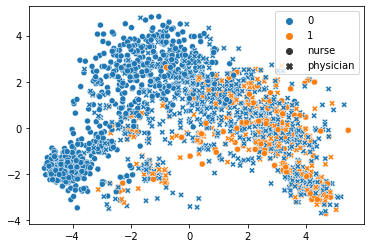

In [35]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_binary)
sn.scatterplot(X_pca[:,0], X_pca[:,1], hue = train_gender_binary, style = train_profs_binary)

In [35]:
x_train_binary.shape

(2306, 100)

In [25]:
x_dev_binary.shape

(2448, 100)

In [295]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    from collections import Counter
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    i2g = {1: "f", 0: "m"}
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        if g == "m":
            g = 0
        if g == "f":
            g = 1
            
        if y == y_hat:
            
            scores[i2p[y]][i2g[g]] += 1
        
        prof_count_total[i2p[y]][i2g[g]] += 1
        
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_f - tpr_m
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def rms_diff(tpr_diff):
    
    return np.sqrt((1/len(tpr_diff)) * np.sum(tpr_diff**2))

def count_profs_and_gender(data):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem, plot=False):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 25)
    #plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 20)
    plt.ylabel('TPR-Gap', fontsize = 25)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.55)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.subplots_adjust(bottom=0.21)
    plt.subplots_adjust(left=0.21)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"r--")
    
    if plot:
        plt.savefig("analysis-results/{}_vs_bias_{}_bert.pdf".format(measure, title), dpi = 1000)
        print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
        plt.show()
        
    return pearsonr(sim_lst, tpr_lst)


def eval_tpr_rms(P, clf, X, y_gender,profs):

    prof2fem = {}
    
    i2p = {w:w for w in set(profs.tolist())}
    p2i = i2p

    y_pred_after = clf.predict((P.dot(X.T)).T)
    tprs, tprs_change, mean_ratio_after = get_TPR(y_pred_after, profs, p2i, i2p, y_gender)
    #similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem) 
    print(tprs)
    change_vals = np.array(list((tprs_change.values())))

    return rms_diff(change_vals)



In [ ]:
import glob

for filename in os.listdir("projs/"):
    if filename.endswith(".pickle"):
        with open("projs/{}".format(filename), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]
            
            
            clf = init_classifier()
            clf.fit(x_train_binary, train_profs_binary)
            score = clf.score(x_dev_binary, dev_profs_binary)
            print("score before", score)
            tpr_before =  eval_tpr_rms(np.eye(768), clf,  x_train_binary, train_gender_binary, train_profs_binary)

            clf = init_classifier()
            clf.fit(x_train_binary@output["P"], train_profs_binary)
            score = clf.score(x_dev_binary@output["P"], dev_profs_binary)
            print("score after", score)
            tpr_after =  eval_tpr_rms(output["P"], clf,  x_train_binary, train_gender_binary, train_profs_binary)
            print(filename, tpr_before, tpr_after)
            print("================")

In [ ]:
0.011318/0.0006811

In [ ]:
help(np.random.choice)

In [484]:
prof1 = "psychologist"
prof2 = "professor"
frac=0.3

with open("projs-imbalanced/{}-{}-prop={}.pickle".format(prof1, prof2, frac), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]
            
with open("pair2frac2Ps-per-class-imbalanced.pickle", "rb") as f:
    pair2frac2Ps = pickle.load(f)
    
P_prof1 = pair2frac2Ps[prof1+"-"+prof2][frac][prof1]["P"]
P_prof2 = pair2frac2Ps[prof1+"-"+prof2][frac][prof2]["P"]

In [485]:
np.abs(P_prof1@P_prof1 - P_prof1).mean()

1.414957813739435e-11

In [486]:
(train_gender_binary[train_profs_binary==prof1]).mean(), (train_gender_binary[train_profs_binary==prof2]).mean()

(0.3, 0.3)

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


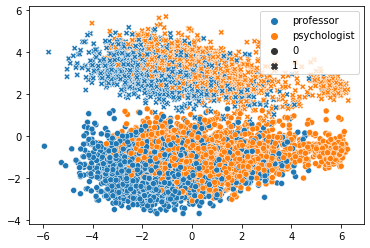

In [487]:
X_pca = PCA(n_components=2).fit_transform(x_train_binary)
sn.scatterplot(X_pca[:,0], X_pca[:,1], hue = train_profs_binary, style = train_gender_binary)

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.6998863636363636

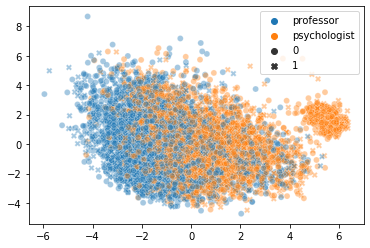

In [489]:
x_train_binary_projected = x_train_binary.copy()
x_train_prof = x_train_binary[train_profs_binary==prof1]
y_train_prof = train_gender_binary[train_profs_binary==prof1]
x_train_binary_projected[train_profs_binary==prof1]= x_train_binary_projected[train_profs_binary==prof1] @ P_prof1
x_train_binary_projected[train_profs_binary==prof2]= x_train_binary_projected[train_profs_binary==prof2] @ P_prof2
X_pca = PCA(n_components=2).fit_transform(x_train_binary_projected)
sn.scatterplot(X_pca[:,0], X_pca[:,1], hue = train_profs_binary, style = train_gender_binary, alpha=0.4)

clf = init_classifier()
clf.fit(x_train_binary_projected, train_gender_binary)
clf.score(x_train_binary_projected, train_gender_binary)

In [432]:
clf = init_classifier()
clf.fit(x_train_binary, train_gender_binary)
clf.score(x_train_binary, train_gender_binary)

0.9997217584863661

In [440]:
clf = init_classifier()
clf.fit(x_train_binary, train_profs_binary)
print("score", clf.score(x_train_binary, train_profs_binary))
print(x_train_binary.shape)
eval_tpr_rms(np.eye(100), clf, x_train_binary, train_gender_binary,train_profs_binary)

score 0.9448154331292895
(21564, 100)
defaultdict(<class 'dict'>, {'physician': {'m': 0.9356120826709062, 'f': 0.9474335188620903}, 'professor': {'m': 0.9553524112347642, 'f': 0.9390847247990105}})


0.014219422906613353

In [434]:
print(Counter(clf.predict(x_train_binary)))
print(Counter(train_profs_binary))
print(Counter(train_gender_binary))
print(Counter(train_gender_binary[train_profs_binary==prof1]), Counter(train_gender_binary[train_profs_binary==prof2]))

Counter({'professor': 10794, 'physician': 10770})
Counter({'physician': 10782, 'professor': 10782})
Counter({0: 15096, 1: 6468})
Counter({0: 7548, 1: 3234}) Counter({0: 7548, 1: 3234})


In [435]:
clf = init_classifier()
n=15000
clf.fit(train_x[:n], train_profs[:n])
clf.score(train_x[:n], train_profs[:n])
eval_tpr_rms(np.eye(100), clf, train_x, train_gender,train_profs)

defaultdict(<class 'dict'>, {'teacher': {'m': 0.38943731490621913, 'f': 0.5502702702702703}, 'professor': {'m': 0.8884469787723418, 'f': 0.8735763423058259}, 'attorney': {'m': 0.8831521739130435, 'f': 0.8356988212653356}, 'photographer': {'m': 0.8441299581423162, 'f': 0.8038434903047091}, 'painter': {'m': 0.7453211009174312, 'f': 0.7307859313938341}, 'psychologist': {'m': 0.5838636363636364, 'f': 0.6521158723801895}, 'filmmaker': {'m': 0.7414650314882334, 'f': 0.7308192457737321}, 'physician': {'m': 0.8, 'f': 0.7696160267111853}, 'interior_designer': {'m': 0.1875, 'f': 0.4894459102902375}, 'architect': {'m': 0.5783132530120482, 'f': 0.5143198090692124}, 'dietitian': {'m': 0.2849462365591398, 'f': 0.6227594831179658}, 'pastor': {'m': 0.641660015961692, 'f': 0.5178571428571429}, 'rapper': {'m': 0.5575757575757576, 'f': 0.3146067415730337}, 'journalist': {'m': 0.7169462828997999, 'f': 0.7502318392581143}, 'dentist': {'m': 0.8373041775456919, 'f': 0.8409990862016449}, 'surgeon': {'m': 0.54

0.18471983463805536

In [289]:
clf.predict(x_train_binary)

array(['physician', 'physician', 'professor', ..., 'surgeon', 'physician',
       'physician'], dtype='<U17')

In [266]:
train_x.shape

(255710, 100)